# Importando módulos 

In [1]:
import obspy
from obspy.taup import TauPyModel

from multiprocessing import Pool
from obspy import read,UTCDateTime,Trace
from obspy.clients.fdsn import Client
import os
import glob
import numpy as np
from collections import defaultdict
import pandas as pd

#para plotar as figuras
import matplotlib.pyplot as plt
from matplotlib.transforms import offset_copy
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition,inset_axes
import matplotlib.colors as colors
import matplotlib.cm as cm
from matplotlib.dates import YearLocator, MonthLocator, DayLocator, HourLocator, MinuteLocator, SecondLocator, DateFormatter
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

from datetime import datetime,timedelta,date
from tqdm import tqdm

from shapely.geometry.polygon import LinearRing

import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Inputs e Outputs

In [3]:
FOLDER_OUTPUT = '/run/media/dIOGOLOC/8d2362fc-3b46-49a7-a864-19b2a6ad097b/diogoloc/dados_posdoc/gliders_project/OUTPUT/'

MSEED_INPUT = "/run/media/dIOGOLOC/8d2362fc-3b46-49a7-a864-19b2a6ad097b/diogoloc/dados_posdoc/gliders_project/OUTPUT/MSEED/"

METADATA_OUTPUT = "/run/media/dIOGOLOC/8d2362fc-3b46-49a7-a864-19b2a6ad097b/diogoloc/dados_posdoc/gliders_project/OUTPUT/METADATA/"

filename_csv = '/run/media/dIOGOLOC/8d2362fc-3b46-49a7-a864-19b2a6ad097b/diogoloc/dados_posdoc/gliders_project/gliders_data/info_csv/metadados_glider_acustico_pmpas-bs.csv'

# Extraindo informações dos arquivos ".mseed"

In [4]:
filenames_MSEED = sorted(glob.glob(MSEED_INPUT+'*/*/*.mseed'))

In [5]:
def mseed_data_2_dataframe(i):
    subdir, filename_wav = os.path.split(i)
    filename = filename_wav.split('.mseed')[0]
    if 'pa' in filename.split('_')[0]:
        mergulho = filename.split('_')[0].split('a')[1]
        stream_number = filename.split('_')[1]

        year_month_day = filename.split('_')[2]
        hour_minute_second = filename.split('_')[3]

        year = int('20'+year_month_day[:2])
        month = int(year_month_day[2:4])
        day = int(year_month_day[4:])

        hour = int(hour_minute_second[:2])
        minute = int(hour_minute_second[2:4])
        second = int(hour_minute_second[4:])

        d = UTCDateTime(datetime(year,month,day,hour,minute,second).isoformat())


    if 'pa' in filename.split('_')[2]:

        mergulho = filename.split('_')[2].split('a')[1]
        stream_number = filename.split('_')[3]

        year_month_day = filename.split('_')[0]
        hour_minute_second = filename.split('_')[1]

        year = int('20'+year_month_day[:2])
        month = int(year_month_day[2:4])
        day = int(year_month_day[4:])

        hour = int(hour_minute_second[:2])
        minute = int(hour_minute_second[2:4])
        second = int(hour_minute_second[4:])

        d = UTCDateTime(datetime(year,month,day,hour,minute,second).isoformat())
        
    
    st = read(i,headonly=True)   
    #----------------------------
    #Starting Dataframe

    starttime = st[0].stats.starttime.datetime
    endtime = st[0].stats.endtime.datetime
    sampling_rate = st[0].stats.sampling_rate
    npts = st[0].stats.npts

    
    df = pd.DataFrame([[filename],[mergulho],[stream_number],[starttime],[endtime],[sampling_rate],[npts]], index=['filename_mseed', 'mergulho', 'stream_number','starttime','endtime','sampling_rate','npts']).T
    
    #Ending Dataframe
    #----------------------------
    return df

In [6]:
pandas_mseed_lst = []

with Pool(processes=8) as p:
    max_ = len(filenames_MSEED)
    with tqdm(total=max_) as pbar:
        for result in p.imap_unordered(mseed_data_2_dataframe,filenames_MSEED):
            pbar.update()
            pandas_mseed_lst.append(result)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 124247/124247 [08:30<00:00, 243.49it/s]


In [7]:
dataframe_mseed_final = pd.concat(pandas_mseed_lst, ignore_index=True)

In [8]:
dataframe_mseed_final.sort_values(by='starttime')

,filename_mseed,mergulho,stream_number,starttime,endtime,sampling_rate,npts
1,pa0001au_001_151112_134841,0001,001,2015-11-12 13:48:41,2015-11-12 13:50:40.930,100.0,11994
15,pa0001au_002_151112_135041,0001,002,2015-11-12 13:50:41,2015-11-12 13:52:40.930,100.0,11994
5,pa0001au_003_151112_135241,0001,003,2015-11-12 13:52:41,2015-11-12 13:54:40.930,100.0,11994
0,pa0001au_004_151112_135441,0001,004,2015-11-12 13:54:41,2015-11-12 13:56:40.930,100.0,11994
7,pa0001au_005_151112_135641,0001,005,2015-11-12 13:56:41,2015-11-12 13:57:00.980,100.0,1999
...,...,...,...,...,...,...,...
124246,pa0296au_008_211104_061338,0296,008,2021-11-04 06:13:38,2021-11-04 06:23:37.990,100.0,60000
124237,pa0296au_009_211104_062338,0296,009,2021-11-04 06:23:38,2021-11-04 06:33:37.990,100.0,60000
124239,pa0296au_010_211104_063338,0296,010,2021-11-04 06:33:38,2021-11-04 06:43:37.990,100.0,60000
124242,pa0296au_011_211104_064338,0296,011,2021-11-04 06:43:38,2021-11-04 06:53:37.990,100.0,60000


In [16]:
dataframe_mseed_final['date'] = dataframe_mseed_final['starttime'].dt.date

In [17]:
dataframe_mseed_final

,filename_mseed,mergulho,stream_number,starttime,endtime,sampling_rate,npts,date
0,pa0001au_004_151112_135441,0001,004,2015-11-12 13:54:41,2015-11-12 13:56:40.930,100.0,11994,2015-11-12
1,pa0001au_001_151112_134841,0001,001,2015-11-12 13:48:41,2015-11-12 13:50:40.930,100.0,11994,2015-11-12
2,pa0002au_004_151112_144218,0002,004,2015-11-12 14:42:18,2015-11-12 14:44:17.930,100.0,11994,2015-11-12
3,pa0002au_002_151112_143818,0002,002,2015-11-12 14:38:18,2015-11-12 14:40:17.930,100.0,11994,2015-11-12
4,pa0002au_001_151112_143618,0002,001,2015-11-12 14:36:18,2015-11-12 14:38:17.930,100.0,11994,2015-11-12
...,...,...,...,...,...,...,...,...
124242,pa0296au_011_211104_064338,0296,011,2021-11-04 06:43:38,2021-11-04 06:53:37.990,100.0,60000,2021-11-04
124243,pa0295au_010_211104_015556,0295,010,2021-11-04 01:55:56,2021-11-04 02:05:55.990,100.0,60000,2021-11-04
124244,pa0296au_012_211104_065338,0296,012,2021-11-04 06:53:38,2021-11-04 06:57:21.780,100.0,22379,2021-11-04
124245,pa0295au_005_211104_010556,0295,005,2021-11-04 01:05:56,2021-11-04 01:15:55.990,100.0,60000,2021-11-04


# Extraindo informações dos arquivos ".csv"

In [21]:
dataframe_csv = pd.read_csv(filename_csv,parse_dates=['time'])
dataframe_csv.sort_values(by='time')

,time,filename,latitude,longitude,depth
0,2015-11-12 13:48:40.999995,pa0001au_001_151112_134841_rms_spl3.mat,-23.825157,-42.495483,1.314286
1,2015-11-12 13:49:41.000001,pa0001au_001_151112_134841_rms_spl3.mat,-23.824950,-42.495487,7.415555
2,2015-11-12 13:50:40.999998,pa0001au_002_151112_135041_rms_spl3.mat,-23.824745,-42.495490,15.776000
3,2015-11-12 13:51:41.000004,pa0001au_002_151112_135041_rms_spl3.mat,-23.824540,-42.495495,24.372000
4,2015-11-12 13:52:41.000001,pa0001au_003_151112_135241_rms_spl3.mat,-23.824331,-42.495500,32.912000
...,...,...,...,...,...
547748,2021-11-04 06:52:38.000000,pa0296au_011_211104_064338_rms_spl3.mat,-24.461742,-42.471264,866.012900
547749,2021-11-04 06:53:37.999997,pa0296au_012_211104_065338_rms_spl3.mat,-24.461819,-42.471302,873.586100
547750,2021-11-04 06:54:38.000003,pa0296au_012_211104_065338_rms_spl3.mat,-24.461980,-42.471510,879.579600
547751,2021-11-04 06:55:38.000000,pa0296au_012_211104_065338_rms_spl3.mat,-24.462152,-42.471740,884.380700


In [22]:
df_csv = dataframe_csv.groupby("filename").agg(pd.Series.tolist)

In [23]:
df_csv['filename_mseed'] = df_csv.index.str.replace('_rms_spl3.mat', '')

/tmp/ipykernel_29812/1878750020.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df_csv['filename_mseed'] = df_csv.index.str.replace('_rms_spl3.mat', '')


In [24]:
df_csv.sort_values(by='time')

,time,latitude,longitude,depth,filename_mseed
filename,,,,,
pa0001au_001_151112_134841_rms_spl3.mat,"[2015-11-12 13:48:40.999995, 2015-11-12 13:49:...","[-23.825157, -23.82495]","[-42.495483, -42.495487]","[1.3142858, 7.4155555]",pa0001au_001_151112_134841
pa0001au_002_151112_135041_rms_spl3.mat,"[2015-11-12 13:50:40.999998, 2015-11-12 13:51:...","[-23.824745, -23.82454]","[-42.49549, -42.495495]","[15.776, 24.372]",pa0001au_002_151112_135041
pa0001au_003_151112_135241_rms_spl3.mat,"[2015-11-12 13:52:41.000001, 2015-11-12 13:53:...","[-23.824331, -23.824125]","[-42.4955, -42.495502]","[32.912, 41.34]",pa0001au_003_151112_135241
pa0001au_004_151112_135441_rms_spl3.mat,"[2015-11-12 13:54:41.000004, 2015-11-12 13:55:41]","[-23.82392, -23.823713]","[-42.495506, -42.495506]","[48.91, 52.824]",pa0001au_004_151112_135441
pa0002au_001_151112_143618_rms_spl3.mat,"[2015-11-12 14:36:17.999998, 2015-11-12 14:37:...","[-23.817575, -23.81744]","[-42.49506, -42.494965]","[1.4671428, 9.36]",pa0002au_001_151112_143618
...,...,...,...,...,...
pa0296au_008_211104_061338_rms_spl3.mat,"[2021-11-04 06:13:37.999999, 2021-11-04 06:14:...","[-24.457632, -24.457657, -24.457726, -24.45786...","[-42.470257, -42.470303, -42.470325, -42.47033...","[550.4096, 559.3073, 567.8462, 575.10706, 582....",pa0296au_008_211104_061338
pa0296au_009_211104_062338_rms_spl3.mat,"[2021-11-04 06:23:38.000003, 2021-11-04 06:24:...","[-24.458628, -24.458672, -24.45872, -24.458822...","[-42.47047, -42.470528, -42.470562, -42.470573...","[629.96436, 637.68353, 646.56323, 654.6224, 66...",pa0296au_009_211104_062338
pa0296au_010_211104_063338_rms_spl3.mat,"[2021-11-04 06:33:37.999998, 2021-11-04 06:34:...","[-24.459415, -24.459513, -24.45957, -24.45963,...","[-42.4708, -42.470802, -42.470856, -42.4709, -...","[706.7263, 715.5506, 722.5956, 730.11316, 737....",pa0296au_010_211104_063338


In [25]:
def name_to_mergulho_stream(filename):
    if 'pa' in filename.split('_')[0]:
        mergulho = filename.split('_')[0].split('a')[1]

    if 'pa' in filename.split('_')[2]:
        mergulho = filename.split('_')[2].split('a')[1]
    
    return mergulho

In [35]:
def calcular_media(lista):
    if len(lista) == 0:
        return None  # Retorna None se a lista estiver vazia para evitar erros
    else:
        return pd.Series(lista).mean()

In [26]:
df_csv['mergulho'] = df_csv['filename_mseed'].apply(name_to_mergulho_stream)

In [36]:
df_csv['date'] = df_csv['time'].apply(calcular_media).dt.date

In [63]:
df_csv

,time,latitude,longitude,depth,filename_mseed,mergulho,date
filename,,,,,,,
160708_172008_pa0003au_001_rms_spl3.mat,"[2016-07-08 17:20:07.999999, 2016-07-08 17:21:...","[-24.391026, -24.391314, -24.391335]","[-43.821663, -43.82173, -43.82174]","[0.9987981, 9.891874, 10.969999]",160708_172008_pa0003au_001,0003,2016-07-08
160708_172307_pa0003au_002_rms_spl3.mat,"[2016-07-08 17:23:07.000004, 2016-07-08 17:24:...","[-24.391356, -24.3916, -24.391617]","[-43.821743, -43.8218, -43.821804]","[12.030156, 23.590548, 24.420235]",160708_172307_pa0003au_002,0003,2016-07-08
160708_172607_pa0003au_003_rms_spl3.mat,"[2016-07-08 17:26:07.000003, 2016-07-08 17:27:...","[-24.391909, -24.39193, -24.392172]","[-43.821873, -43.82188, -43.821938]","[36.456642, 37.333202, 47.245785]",160708_172607_pa0003au_003,0003,2016-07-08
160708_172906_pa0003au_004_rms_spl3.mat,"[2016-07-08 17:29:05.999998, 2016-07-08 17:30:...","[-24.392193, -24.392475, -24.392496]","[-43.82194, -43.822006, -43.82201]","[48.01094, 58.52969, 59.289062]",160708_172906_pa0003au_004,0003,2016-07-08
160708_173205_pa0003au_005_rms_spl3.mat,"[2016-07-08 17:32:05.000003, 2016-07-08 17:33:...","[-24.392744, -24.392765, -24.393057]","[-43.822067, -43.822075, -43.822144]","[68.57156, 69.49031, 80.89149]",160708_173205_pa0003au_005,0003,2016-07-08
...,...,...,...,...,...,...,...
pa0626au_041_160418_075202_rms_spl3.mat,"[2016-04-18 07:52:02.000001, 2016-04-18 07:53:...","[-24.46632, -24.466305]","[-43.148865, -43.14886]","[897.4117, 899.9383]",pa0626au_041_160418_075202,0626,2016-04-18
pa0626au_042_160418_075402_rms_spl3.mat,"[2016-04-18 07:54:02.000004, 2016-04-18 07:55:02]","[-24.466183, -24.466167]","[-43.14885, -43.148846]","[918.85736, 921.4589]",pa0626au_042_160418_075402,0626,2016-04-18
pa0626au_043_160418_075602_rms_spl3.mat,"[2016-04-18 07:56:01.999997, 2016-04-18 07:57:...","[-24.466047, -24.466032]","[-43.148834, -43.14883]","[940.0661, 942.0864]",pa0626au_043_160418_075602,0626,2016-04-18


In [66]:
df_csv['lat'] =  df_csv['latitude'].apply(calcular_media)
df_csv['lon'] =  df_csv['longitude'].apply(calcular_media)
df_csv['dep'] =  df_csv['depth'].apply(calcular_media)

In [70]:
df_csv_mean = df_csv.drop(columns=['time','latitude','longitude','depth',])

In [71]:
df_csv_mean

,filename_mseed,mergulho,date,lat,lon,dep
filename,,,,,,
160708_172008_pa0003au_001_rms_spl3.mat,160708_172008_pa0003au_001,0003,2016-07-08,-24.391225,-43.821711,7.286890
160708_172307_pa0003au_002_rms_spl3.mat,160708_172307_pa0003au_002,0003,2016-07-08,-24.391524,-43.821782,20.013646
160708_172607_pa0003au_003_rms_spl3.mat,160708_172607_pa0003au_003,0003,2016-07-08,-24.392004,-43.821897,40.345210
160708_172906_pa0003au_004_rms_spl3.mat,160708_172906_pa0003au_004,0003,2016-07-08,-24.392388,-43.821985,55.276564
160708_173205_pa0003au_005_rms_spl3.mat,160708_173205_pa0003au_005,0003,2016-07-08,-24.392855,-43.822095,72.984453
...,...,...,...,...,...,...
pa0626au_041_160418_075202_rms_spl3.mat,pa0626au_041_160418_075202,0626,2016-04-18,-24.466313,-43.148862,898.675000
pa0626au_042_160418_075402_rms_spl3.mat,pa0626au_042_160418_075402,0626,2016-04-18,-24.466175,-43.148848,920.158130
pa0626au_043_160418_075602_rms_spl3.mat,pa0626au_043_160418_075602,0626,2016-04-18,-24.466040,-43.148832,941.076250


In [74]:
df_mergulho = df_csv_mean.groupby(["date", "mergulho"]).agg(pd.Series.tolist)

In [75]:
df_mergulho.sort_values(by='date')

filename_mseed  \
date       mergulho                                                      
2015-11-12 0001      [pa0001au_001_151112_134841, pa0001au_002_1511...   
           0002      [pa0002au_001_151112_143618, pa0002au_002_1511...   
           0003      [pa0003au_001_151112_153548, pa0003au_002_1511...   
           0004      [pa0004au_001_151112_174207, pa0004au_002_1511...   
           0005      [pa0005au_001_151112_204336, pa0005au_002_1511...   
...                                                                ...   
2021-11-02 0288      [pa0288au_001_211102_124025, pa0288au_002_2111...   
2021-11-03 0291      [pa0291au_001_211103_033804, pa0291au_002_2111...   
           0292      [pa0292au_001_211103_091641, pa0292au_002_2111...   
2021-11-04 0295      [pa0295au_001_211104_002556, pa0295au_002_2111...   
           0296      [pa0296au_001_211104_050338, pa0296au_002_2111...   

                                                                   lat  \
date       mergulho                                                      
2015-11-12 0001      [-23.825053500000003, -23.8246425, -23.8242279...   
           0002      [-23.8175075, -23.817236, -23.816964, -23.8166...   
           0003      [-23.8102255, -23.809901, -23.809576, -23.8092...   
           0004      [-23.791143499999997, -23.791131, -23.79111850...   
           0005      [-23.7855565, -23.785538, -23.7855195, -23.785...   
...                                                                ...   
2021-11-02 0288      [-24.3308765, -24.331216700000002, -24.3315312...   
2021-11-03 0291      [-24.3488883, -24.3499197, -24.3510136, -24.35...   
           0292      [-24.3730066, -24.373596600000006, -24.3742725...   
2021-11-04 0295      [-24.4330778, -24.433873400000003, -24.4346555...   
           0296      [-24.4520911, -24.4530278, -24.4540274, -24.45...   

                                                                   lon  \
date       mergulho                                                      
2015-11-12 0001      [-42.495485, -42.4954925, -42.495501000000004,...   
           0002      [-42.4950125, -42.4948155, -42.494619, -42.494...   
           0003      [-42.490898, -42.490516, -42.490133, -42.48975...   
           0004      [-42.474413, -42.4743435, -42.474274, -42.4742...   
           0005      [-42.470098, -42.470031500000005, -42.469965, ...   
...                                                                ...   
2021-11-02 0288      [-42.4342379, -42.4343096, -42.434333800000005...   
2021-11-03 0291      [-42.423682, -42.423715099999995, -42.42402259...   
           0292      [-42.4287757, -42.4289428, -42.42958409999999,...   
2021-11-04 0295      [-42.4643029, -42.4644099, -42.464621699999995...   
           0296      [-42.4683766, -42.468583699999996, -42.4688643...   

                                                                   dep  
date       mergulho                                                     
2015-11-12 0001      [4.36492065, 20.073999999999998, 37.1260000000...  
           0002      [5.4135713999999995, 22.215, 39.36, 55.1449999...  
           0003      [5.27500005, 22.48, 41.61, 59.117498499999996,...  
           0004      [6.82942855, 26.9466665, 46.4133335, 64.314373...  
           0005      [8.6875, 30.728499999999997, 49.85500000000000...  
...                                                                ...  
2021-11-02 0288      [32.012692120000004, 93.83984930000001, 152.98...  
2021-11-03 0291      [32.765059840000006, 98.9102498, 160.262993, 2...  
           0292      [32.757662270000004, 95.8908208, 153.823986, 2...  
2021-11-04 0295      [37.54630839000001, 120.18414149999998, 193.00...  
           0296      [40.23409385, 123.3260444, 198.69117500000002,...  

[4118 rows x 4 columns]

In [76]:
df_mergulho['lat'] =  df_mergulho['lat'].apply(calcular_media)
df_mergulho['lon'] =  df_mergulho['lon'].apply(calcular_media)
df_mergulho['dep'] =  df_mergulho['dep'].apply(calcular_media)

In [102]:
df_mergulho_feather = df_mergulho.reset_index()

In [103]:
df_mergulho_feather

,date,mergulho,filename_mseed,lat,lon,dep
0,2015-11-12,0001,"[pa0001au_001_151112_134841, pa0001au_002_1511...",-23.824435,-42.495496,28.107980
1,2015-11-12,0002,"[pa0002au_001_151112_143618, pa0002au_002_1511...",-23.816693,-42.494423,54.389724
2,2015-11-12,0003,"[pa0003au_001_151112_153548, pa0003au_002_1511...",-23.807137,-42.487275,159.719170
3,2015-11-12,0004,"[pa0004au_001_151112_174207, pa0004au_002_1511...",-23.790957,-42.473373,264.914544
4,2015-11-12,0005,"[pa0005au_001_151112_204336, pa0005au_002_1511...",-23.785264,-42.469056,283.000283
...,...,...,...,...,...,...
4113,2021-11-02,0288,"[pa0288au_001_211102_124025, pa0288au_002_2111...",-24.334206,-42.434063,490.726565
4114,2021-11-03,0291,"[pa0291au_001_211103_033804, pa0291au_002_2111...",-24.356838,-42.425637,509.938108
4115,2021-11-03,0292,"[pa0292au_001_211103_091641, pa0292au_002_2111...",-24.378415,-42.430636,500.532732
4116,2021-11-04,0295,"[pa0295au_001_211104_002556, pa0295au_002_2111...",-24.437741,-42.464982,460.269513


In [104]:
df_mergulho_feather.to_feather('/home/dIOGOLOC/Documents/df_mergulho.feather')

In [83]:
df_mergulho_date = [i[0] for i in df_mergulho.index]

In [95]:
df_mergulho['filename_mseed'][0]

['pa0001au_001_151112_134841',
 'pa0001au_002_151112_135041',
 'pa0001au_003_151112_135241',
 'pa0001au_004_151112_135441']

In [96]:
df_mergulho['filename_mseed'][1]

['pa0002au_001_151112_143618',
 'pa0002au_002_151112_143818',
 'pa0002au_003_151112_144018',
 'pa0002au_004_151112_144218',
 'pa0002au_005_151112_144418',
 'pa0002au_006_151112_144618',
 'pa0002au_007_151112_144818']

In [97]:
df_mergulho['filename_mseed'][2]

['pa0003au_001_151112_153548',
 'pa0003au_002_151112_153748',
 'pa0003au_003_151112_153948',
 'pa0003au_004_151112_154148',
 'pa0003au_005_151112_154348',
 'pa0003au_006_151112_154548',
 'pa0003au_007_151112_154748',
 'pa0003au_008_151112_154948',
 'pa0003au_009_151112_155148',
 'pa0003au_010_151112_155348',
 'pa0003au_011_151112_155548',
 'pa0003au_012_151112_155748',
 'pa0003au_013_151112_155948',
 'pa0003au_014_151112_160148',
 'pa0003au_015_151112_160348',
 'pa0003au_016_151112_160547',
 'pa0003au_017_151112_160747',
 'pa0003au_018_151112_160947',
 'pa0003au_019_151112_161147',
 'pa0003au_020_151112_161347']

# Plotando o dataframe com os mergulhos: 

/tmp/ipykernel_29812/1018589.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1, 1, 1, projection=proj)


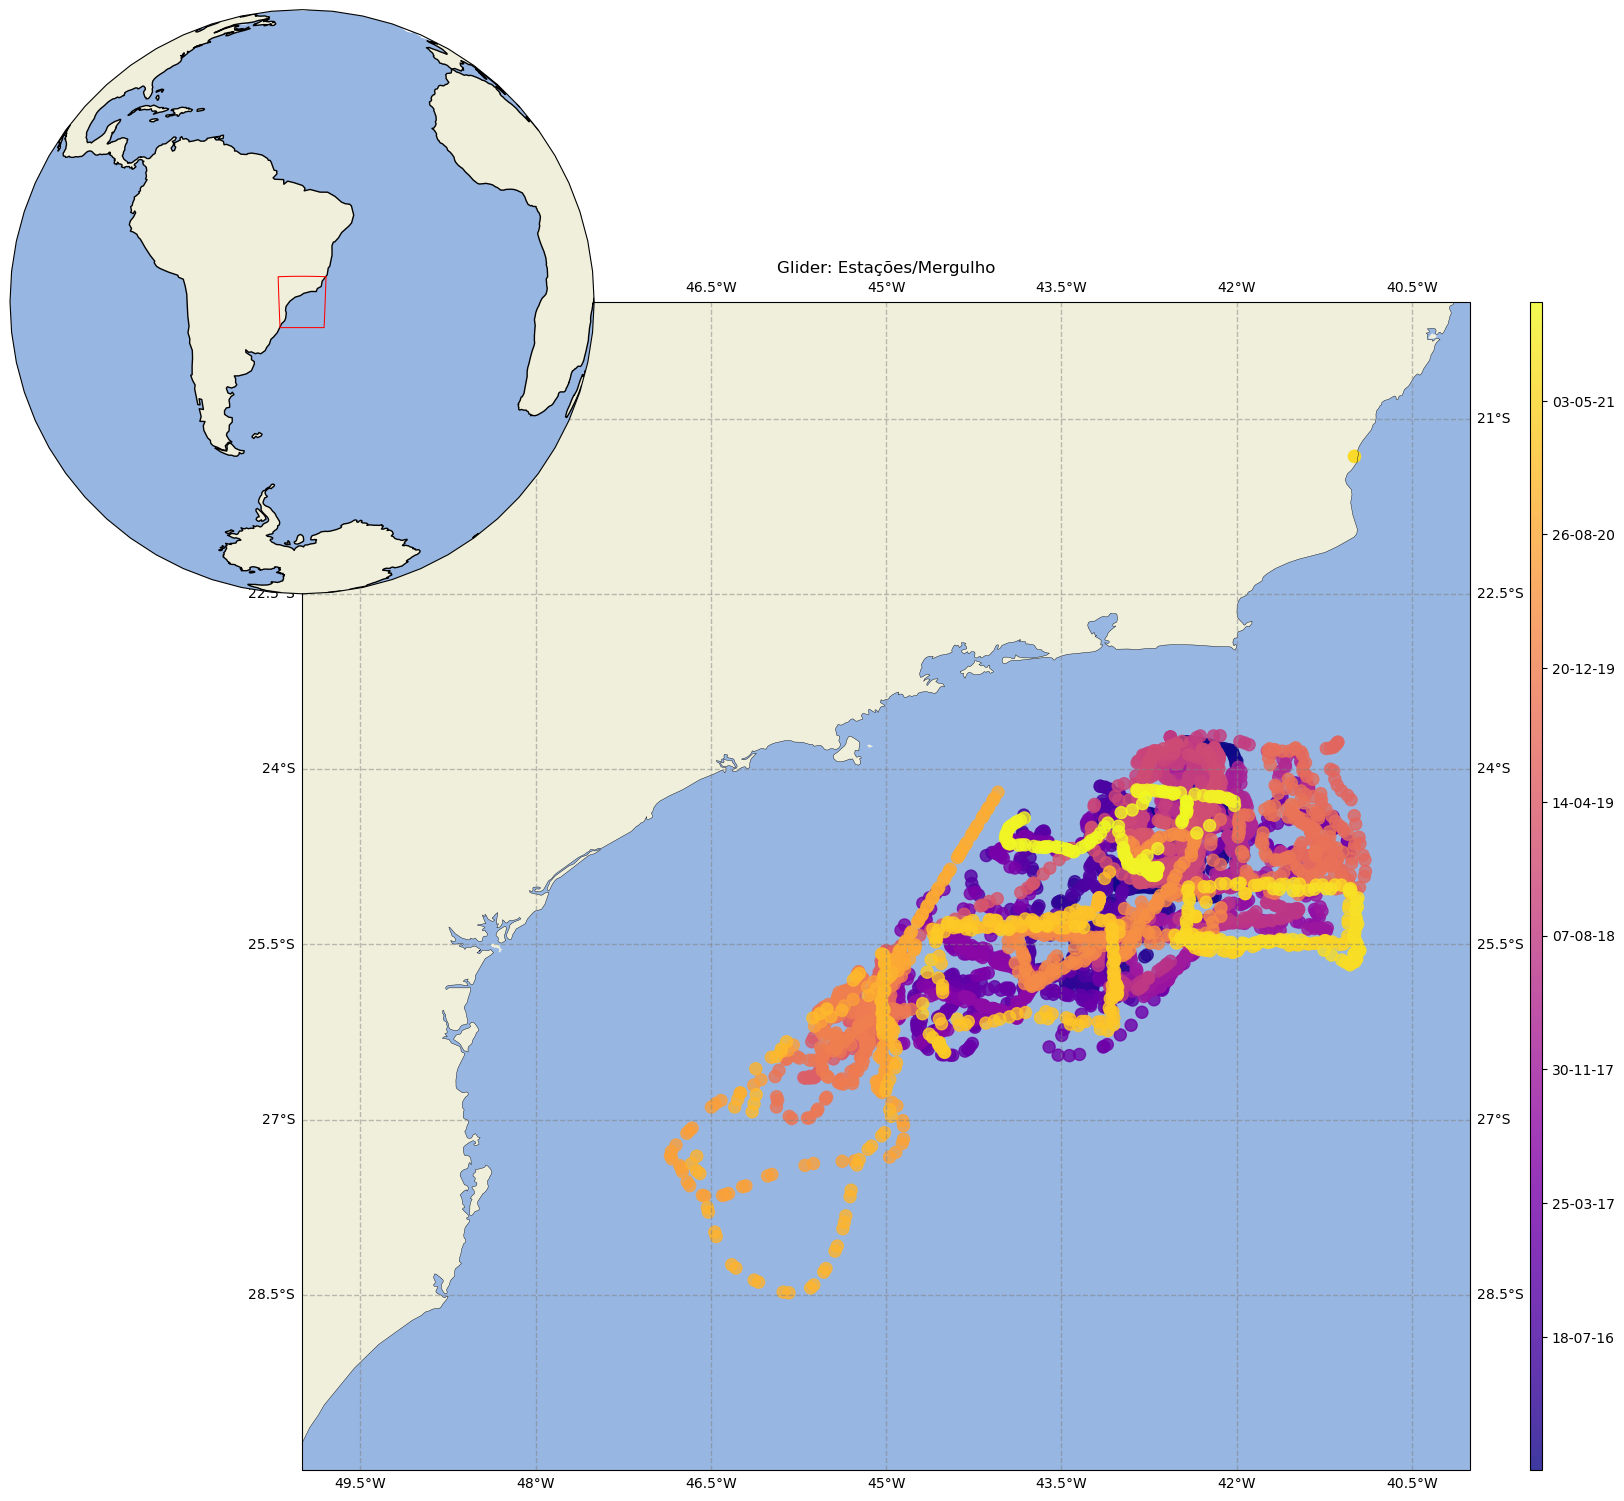

In [88]:

#########################################################################################################################################################
#Figure 

# set up the plot and create a GeoAxes:
proj = ccrs.PlateCarree()

fig, ax = plt.subplots(1,1,figsize=(16,16))
ax = plt.subplot(1, 1, 1, projection=proj)
                    
# ----------------------------------------------------------------------------------------------------------
# Limit the extent of the map to a small longitude/latitude range.
latmin=-30
latmax=-20
lonmin=-50
lonmax=-40

ax.set_extent([lonmin,lonmax, latmin, latmax], crs=ccrs.Geodetic())

# ----------------------------------------------------------------------------------------------------------
# Ploting lat/lon values
                
h = ax.scatter(df_mergulho['lon'].values,df_mergulho['lat'].values,c=np.array([mdates.date2num(i) for i in df_mergulho_date]),marker='o',alpha=0.8,cmap='plasma',s=75,transform=proj)

# ----------------------------------------------------------------------------------------------------------
# Adding background map 
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE,linewidth=0.3)
ax.add_feature(cfeature.BORDERS, linestyle=':',linewidth=0.3)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.set_title('Glider: Estações/Mergulho')
    
# ----------------------------------------------------------------------------------------------------------
# Adding colorbar
divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="1%", pad=0.6, axes_class=plt.Axes)

fig.add_axes(ax_cb)
cb = plt.colorbar(h, cax=ax_cb)
cb.ax.yaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))
   
# ----------------------------------------------------------------------------------------------------------
# Adding global location map
# inset location relative to main plot (ax) in normalized units
inset_x = 0
inset_y = 1
inset_size = 0.5

# Adding Geoaxes
ax2 = plt.axes([0, 0, 1, 1], projection=ccrs.Orthographic(central_latitude=(latmin + latmax)/2,central_longitude=(lonmin + lonmax) / 2))
ax2.set_global()

# Adding background map 
ax2.add_feature(cfeature.LAND)
ax2.add_feature(cfeature.OCEAN)
ax2.add_feature(cfeature.COASTLINE)

# Adding inset geoaxes position
ip = InsetPosition(ax, [inset_x - inset_size / 2,
                          inset_y - inset_size / 2,
                          inset_size,inset_size])
    
ax2.set_axes_locator(ip)


# Adding red rectangle position
nvert = 100
lons = np.r_[np.linspace(lonmin, lonmin, nvert),
                                 np.linspace(lonmin, lonmax, nvert),
                                 np.linspace(lonmax, lonmax, nvert)].tolist()
    
lats = np.r_[np.linspace(latmin, latmax, nvert),
                                 np.linspace(latmax, latmax, nvert),
                                 np.linspace(latmax, latmin, nvert)].tolist()

ring = LinearRing(list(zip(lons, lats)))
ax2.add_geometries([ring], ccrs.PlateCarree(),facecolor='none', edgecolor='red', linewidth=0.75)

        
# ----------------------------------------------------------------------------------------------------------
# Saving figure
#os.makedirs(FOLDER_OUTPUT+'FIGURAS/INTERP_MSEED/'+st[0].stats.starttime.strftime('%Y')+'/'+st[0].stats.starttime.strftime('%Y-%m-%d')+'/',exist_ok=True)
#fig.savefig(FOLDER_OUTPUT+'FIGURAS/INTERP_MSEED/'+st[0].stats.starttime.strftime('%Y')+'/'+st[0].stats.starttime.strftime('%Y-%m-%d')+'/'+'interp_mseed_'+file_n_meta+'.png')
#plt.close()